# Sistemas de recomendación


In [ ]:
#!pip install scikit-surprise

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from surprise import Reader
from surprise import Dataset
from surprise.model_selection import cross_validate
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import KNNBaseline
from surprise import SVD
from surprise import BaselineOnly
from surprise import NMF
from surprise import SlopeOne
from surprise import CoClustering
from surprise import accuracy
from surprise.model_selection import train_test_split

In [2]:
user = pd.read_csv(
    'https://github.com/DiploDatos/AprendizajeSupervisado/raw/master/Te%C3%B3rico/demo_11_dataset/BX-Users.csv', sep=';', encoding="latin-1")

user.columns = ['userID', 'Location', 'Age']

rating = pd.read_csv(
    'https://github.com/DiploDatos/AprendizajeSupervisado/raw/master/Te%C3%B3rico/demo_11_dataset/BX-Book-Ratings.csv', sep=';', encoding="latin-1")

rating.columns = ['userID', 'ISBN', 'bookRating']

df = pd.merge(user, rating, on='userID', how='inner')

df.drop(['Location', 'Age'], axis=1, inplace=True)

df.head()

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   userID      1149780 non-null  int64 
 1   ISBN        1149780 non-null  object
 2   bookRating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


Veamos la distribución de las valoraciones


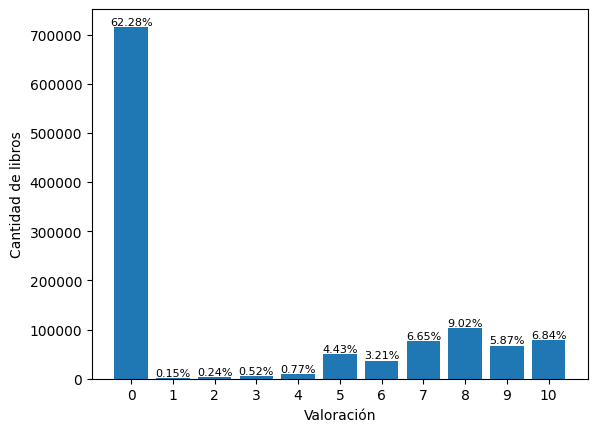

In [4]:
data = df['bookRating'].value_counts().sort_index(ascending=False)

p1 = plt.bar(data.index, data.values)

for rect1 in p1:
    height = rect1.get_height()
    plt.annotate(f"{height/data.values.sum()*100:.2f}%", (rect1.get_x() +
                 rect1.get_width()/2, height+.05), ha="center", va="bottom", fontsize=8)

plt.xticks(np.arange(0, 11, 1))
plt.ylabel('Cantidad de libros')
plt.xlabel('Valoración')
plt.show()

Veamos cómo es la distribución de número de valoraciones por libro


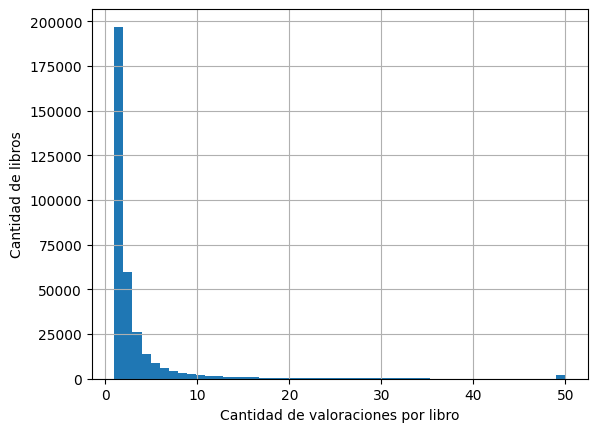

In [5]:
data = df.groupby('ISBN')['bookRating'].count()

data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por libro')
plt.ylabel('Cantidad de libros')
plt.show()

In [6]:
# Los 10 libros más votados
data.sort_values(ascending=False)[:10]

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
044023722X     647
0679781587     639
0142001740     615
067976402X     614
0671027360     586
Name: bookRating, dtype: int64

Ahora podemos pensar en la distribución de cantidad de valoraciones por usuario


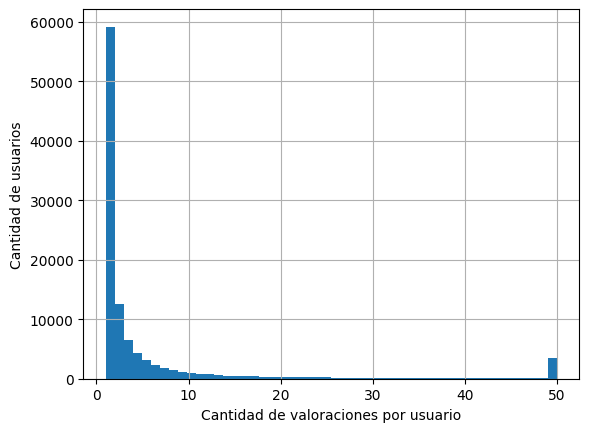

In [7]:
data = df.groupby('userID')['bookRating'].count()
data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por usuario')
plt.ylabel('Cantidad de usuarios')
plt.show()

La mayoria de los usuarios dan menos de 10 valoraciones. Cuántas valoraciones dio el usuario más activo?


In [8]:
df

,userID,ISBN,bookRating
0,2,0195153448,0
1,7,034542252,0
2,8,0002005018,5
3,8,0060973129,0
4,8,0374157065,0
...,...,...,...
1149775,278854,0425163393,7
1149776,278854,0515087122,0
1149777,278854,0553275739,6
1149778,278854,0553578596,0


In [9]:
df.groupby('userID')['bookRating'].count().sort_values(ascending=False)[:5]

userID
11676     13602
198711     7550
153662     6109
98391      5891
35859      5850
Name: bookRating, dtype: int64

Tanto el número de valoraciones por libro y el número de valoraciones por usuario tienen distribuciones que decaen exponencialmente!


Para evitar problemas de memoria, vamos a filtrar los libros y los usuarios "outlayers".


In [10]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books = filter_books[filter_books].index.tolist()

min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()

df_new = df[(df['ISBN'].isin(filter_books)) &
            (df['userID'].isin(filter_users))]
print('The original data frame shape:\t{}'.format(df.shape))
print('The new data frame shape:\t{}'.format(df_new.shape))

The original data frame shape:	(1149780, 3)
The new data frame shape:	(140516, 3)


Armamos un array booleano que nos indica cuáles ISBN's cumplen con la condición lógica de al menos tener 50 ratings


In [11]:
min_book_ratings = 50
filter_books = df['ISBN'].value_counts() > min_book_ratings
filter_books

ISBN
0971880107     True
0316666343     True
0385504209     True
0060928336     True
0312195516     True
              ...  
0916211223    False
0916211231    False
0916211274    False
0916211282    False
1569661057    False
Name: count, Length: 340556, dtype: bool

Luego, nos quedamos sólo con los que los cumplen


In [12]:
filter_books = filter_books[filter_books].index.tolist()
filter_books

['0971880107',
 '0316666343',
 '0385504209',
 '0060928336',
 '0312195516',
 '044023722X',
 '0679781587',
 '0142001740',
 '067976402X',
 '0671027360',
 '0446672211',
 '059035342X',
 '0316601950',
 '0375727345',
 '044021145X',
 '0452282152',
 '0440214041',
 '0804106304',
 '0440211727',
 '0345337662',
 '0060930535',
 '0440226430',
 '0312278586',
 '0743418174',
 '0671021001',
 '0345370775',
 '0446605239',
 '0156027321',
 '0440241073',
 '0671003755',
 '0060976845',
 '1400034779',
 '0786868716',
 '0440234743',
 '0440222656',
 '0440221471',
 '0345361792',
 '0440236673',
 '0345417623',
 '0316769487',
 '0446610038',
 '0385484518',
 '0446310786',
 '044022165X',
 '0375706771',
 '0440225701',
 '0440220602',
 '0060502258',
 '0446606812',
 '0345353145',
 '044651652X',
 '0140293248',
 '0345443284',
 '0440206154',
 '0440213525',
 '006101351X',
 '0316284955',
 '0312291639',
 '0375707972',
 '0439064872',
 '0060934417',
 '0385335482',
 '0671510053',
 '0440224764',
 '0452282829',
 '0385492081',
 '06848447

In [13]:
condicion1 = (df['ISBN'].isin(filter_books))
df[condicion1]['ISBN'].value_counts()

ISBN
0971880107    2502
0316666343    1295
0385504209     883
0060928336     732
0312195516     723
              ... 
0812513711      51
0671020293      51
0670896764      51
0394281802      51
0446613053      51
Name: count, Length: 2125, dtype: int64

Hacemos lo mismo con los usuarios


In [14]:
min_user_ratings = 50
filter_users = df['userID'].value_counts() > min_user_ratings
filter_users = filter_users[filter_users].index.tolist()
condicion2 = (df['userID'].isin(filter_users))
df_new = df[(condicion2 & condicion1)]

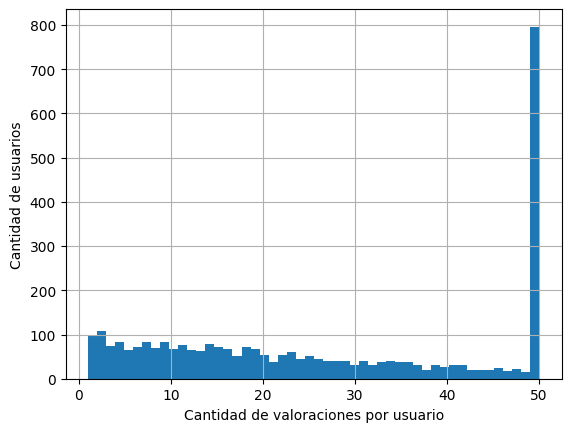

In [15]:
data = df_new.groupby('userID')['bookRating'].count()
data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por usuario')
plt.ylabel('Cantidad de usuarios')
plt.show()

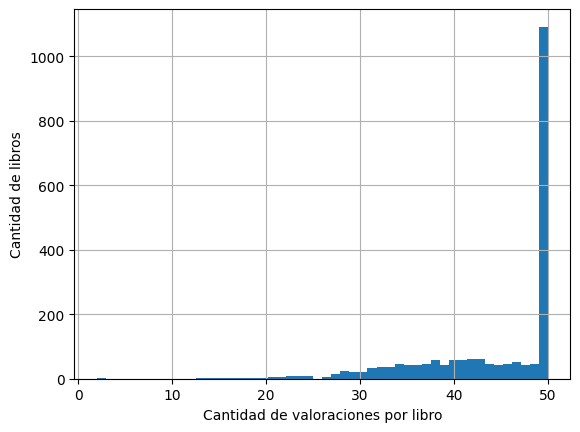

In [16]:
data = df_new.groupby('ISBN')['bookRating'].count()

data.clip(upper=50).hist(bins=50)
plt.xlabel('Cantidad de valoraciones por libro')
plt.ylabel('Cantidad de libros')
plt.show()

## Búsqueda del mejor modelo


In [17]:
reader = Reader(rating_scale=(1, 10))  # 0 = N/A
data = Dataset.load_from_df(df_new[['userID', 'ISBN', 'bookRating']], reader)

benchmark = []
# Iterate over all algorithms
for i, algorithm in enumerate([SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(),  # SVDpp
                               KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]):
    # Perform cross validation
    print(i)
    try:
        results = cross_validate(algorithm, data, measures=[
                                 'RMSE'], cv=3, verbose=False)
        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp._append(pd.Series([str(algorithm).split(
            ' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)
        print(tmp)
    except:
        continue

0
test_rmse    3.529184
fit_time     0.796471
test_time    0.255839
Algorithm         SVD
dtype: object
1
test_rmse     3.46212
fit_time     0.517012
test_time    2.384688
Algorithm    SlopeOne
dtype: object
2
test_rmse    3.865731
fit_time     1.748216
test_time    0.220005
Algorithm         NMF
dtype: object
3
test_rmse           4.598378
fit_time               0.096
test_time              0.211
Algorithm    NormalPredictor
dtype: object
4
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
test_rmse       3.482644
fit_time        0.749754
test_time       3.115554
Algorithm    KNNBaseline
dtype: object
5
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing

[Overview](https://www.kdnuggets.com/2017/08/recommendation-system-algorithms-overview.html) de los algoritmos


Algunos:

- NormalPredictor : $\hat{r}_{ui}$ se muestrea de una distribución gaussiana con media $\hat{\mu}$ y desvío $\hat{\sigma}^2$ obtenidos por máxima verosimilitud utilizando los datos de entrenamiento.

- [BaselineOnly](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#baseline-estimates-configuration) : $\hat{r}_{ui} = \mu + b_u + b_i$

- [kNNBasic](https://surprise.readthedocs.io/en/stable/prediction_algorithms.html#similarity-measures-configuration) : $\hat{r}_{ui} = \frac{\sum_{v \in vecinos}sim(u,v) \cdot r_{vi}}{\sum_{v \in vecinos} sim(u,v)}$

- [Matrix factorization](https://surprise.readthedocs.io/en/stable/matrix_factorization.html) : $\hat{r}_{ui} = \mu + b_u + b_i + q_i^T p_u$ (si $\mu$, $b_u$ y $b_i$ son 0 se llama Probabilistic Matrix Factorization)


In [18]:
benchmark

[test_rmse    3.529184
 fit_time     0.796471
 test_time    0.255839
 Algorithm         SVD
 dtype: object,
 test_rmse     3.46212
 fit_time     0.517012
 test_time    2.384688
 Algorithm    SlopeOne
 dtype: object,
 test_rmse    3.865731
 fit_time     1.748216
 test_time    0.220005
 Algorithm         NMF
 dtype: object,
 test_rmse           4.598378
 fit_time               0.096
 test_time              0.211
 Algorithm    NormalPredictor
 dtype: object,
 test_rmse       3.482644
 fit_time        0.749754
 test_time       3.115554
 Algorithm    KNNBaseline
 dtype: object,
 test_rmse    3.687375
 fit_time     0.526351
 test_time    2.539071
 Algorithm    KNNBasic
 dtype: object,
 test_rmse        3.483504
 fit_time         0.559675
 test_time         2.77833
 Algorithm    KNNWithMeans
 dtype: object,
 test_rmse         3.501789
 fit_time          0.669859
 test_time         2.936385
 Algorithm    KNNWithZScore
 dtype: object,
 test_rmse        3.386847
 fit_time         0.183673
 test_

In [19]:
surprise_results = pd.DataFrame(benchmark).set_index(
    'Algorithm').sort_values('test_rmse')

surprise_results

,test_rmse,fit_time,test_time
Algorithm,,,
BaselineOnly,3.386847,0.183673,0.247337
CoClustering,3.460214,1.980391,0.247676
SlopeOne,3.462120,0.517012,2.384688
KNNBaseline,3.482644,0.749754,3.115554
KNNWithMeans,3.483504,0.559675,2.778330
KNNWithZScore,3.501789,0.669859,2.936385
SVD,3.529184,0.796471,0.255839
KNNBasic,3.687375,0.526351,2.539071
NMF,3.865731,1.748216,0.220005


## Selección de modelo y selección de hiperparámetros


Nos quedamos con el algoritmo `BaselineOnly()`. Además vamos a utilizar el método [Alternating Least Squares](https://sophwats.github.io/2018-04-05-gentle-als.html) para encontrar los $b_u$ y $b_i$


In [20]:
print('Using ALS')
bsl_options = {'method': 'als',
               'n_epochs': 5,
               'reg_u': 12,
               'reg_i': 5
               }
algo = BaselineOnly(bsl_options=bsl_options)
cross_validate(algo, data, measures=['RMSE'], cv=3, verbose=False)

Using ALS
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...


{'test_rmse': array([3.36869256, 3.39266491, 3.38793465]),
 'fit_time': (0.09599995613098145, 0.11800003051757812, 0.11900067329406738),
 'test_time': (0.1809999942779541, 0.18200016021728516, 0.1809992790222168)}

In [21]:
trainset, testset = train_test_split(data, test_size=0.25)
algo = BaselineOnly(bsl_options=bsl_options)
predictions = algo.fit(trainset).test(testset)

Estimating biases using als...


## Analizando los resultados


In [22]:
predictions

[Prediction(uid=184532, iid='0345391055', r_ui=0.0, est=4.56943160457701, details={'was_impossible': False}),
 Prediction(uid=16916, iid='0440222656', r_ui=7.0, est=1.3692118772688908, details={'was_impossible': False}),
 Prediction(uid=11676, iid='0440219078', r_ui=7.0, est=5.805108313741267, details={'was_impossible': False}),
 Prediction(uid=57398, iid='0446605239', r_ui=0.0, est=3.7552795607077596, details={'was_impossible': False}),
 Prediction(uid=12538, iid='038542471X', r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=129465, iid='0425122123', r_ui=0.0, est=1, details={'was_impossible': False}),
 Prediction(uid=13552, iid='0670032379', r_ui=0.0, est=3.9947992022498706, details={'was_impossible': False}),
 Prediction(uid=162052, iid='0684195488', r_ui=0.0, est=4.325329169617912, details={'was_impossible': False}),
 Prediction(uid=236757, iid='067164257X', r_ui=0.0, est=2.270320761687512, details={'was_impossible': False}),
 Prediction(uid=28619, iid='03855038

In [23]:
accuracy.rmse(predictions)

RMSE: 3.3490


3.3490318336618254

In [24]:
trainset = algo.trainset
print(algo.__class__.__name__)

BaselineOnly


In [25]:
def get_Iu(uid):
    """ return the number of items rated by given user
    args: 
      uid: the id of the user
    returns: 
      the number of items rated by the user
    """
    try:
        return len(trainset.ur[trainset.to_inner_uid(uid)])
    except ValueError:  # user was not part of the trainset
        return 0


def get_Ui(iid):
    """ return number of users that have rated given item
    args:
      iid: the raw id of the item
    returns:
      the number of users that have rated the item.
    """
    try:
        return len(trainset.ir[trainset.to_inner_iid(iid)])
    except ValueError:
        return 0


df = pd.DataFrame(predictions, columns=['uid', 'iid', 'rui', 'est', 'details'])
df['Iu'] = df.uid.apply(get_Iu)
df['Ui'] = df.iid.apply(get_Ui)
df['err'] = abs(df.est - df.rui)

In [26]:
df.head()

,uid,iid,rui,est,details,Iu,Ui,err
0,184532,0345391055,0.0,4.569432,{'was_impossible': False},29,107,4.569432
1,16916,0440222656,7.0,1.369212,{'was_impossible': False},80,192,5.630788
2,11676,0440219078,7.0,5.805108,{'was_impossible': False},1146,56,1.194892
3,57398,0446605239,0.0,3.755280,{'was_impossible': False},35,208,3.755280
4,12538,038542471X,0.0,1.000000,{'was_impossible': False},123,46,1.000000


Podemos guardar las mejores y peores predicciones


In [27]:
best_predictions = df.sort_values(by='err')[:10]
worst_predictions = df.sort_values(by='err')[-10:]

In [28]:
best_predictions

,uid,iid,rui,est,details,Iu,Ui,err
13330,129851,0971880107,1.0,1.000000,{'was_impossible': False},37,636,0.000000
3336,40943,0312288115,1.0,1.000000,{'was_impossible': False},124,32,0.000000
26997,41667,0971880107,1.0,1.000000,{'was_impossible': False},9,636,0.000000
23682,233911,0345427637,1.0,1.000000,{'was_impossible': False},44,76,0.000000
19655,170595,0425178765,1.0,1.000000,{'was_impossible': False},21,62,0.000000
30495,177432,0345391810,7.0,6.997455,{'was_impossible': False},50,26,0.002545
25244,251140,0671534734,4.0,3.996327,{'was_impossible': False},48,35,0.003673
25891,91184,0439136369,5.0,4.994891,{'was_impossible': False},9,91,0.005109
16058,273113,0373270976,5.0,4.993634,{'was_impossible': False},43,30,0.006366
15630,267635,0446606383,3.0,3.010606,{'was_impossible': False},30,37,0.010606


In [29]:
worst_predictions

,uid,iid,rui,est,details,Iu,Ui,err
23622,69232,051513287X,10.0,1.000000,{'was_impossible': False},145,114,9.000000
24185,130474,0399149392,10.0,1.000000,{'was_impossible': False},188,24,9.000000
6665,172742,0743225406,10.0,1.000000,{'was_impossible': False},191,76,9.000000
19998,117594,0553099558,10.0,1.000000,{'was_impossible': False},48,33,9.000000
30822,277427,0451203593,10.0,1.000000,{'was_impossible': False},114,28,9.000000
3564,43842,0345438825,10.0,1.000000,{'was_impossible': False},188,29,9.000000
12658,204964,0441478123,10.0,1.000000,{'was_impossible': False},17,28,9.000000
8793,69697,0425181464,10.0,1.000000,{'was_impossible': False},146,47,9.000000
15365,31826,043935806X,0.0,9.736661,{'was_impossible': False},79,160,9.736661
235,31826,0590353403,0.0,10.000000,{'was_impossible': False},79,75,10.000000


Qué está pasando con esos casos?


In [30]:
book = '0590353403'
df_new.loc[df_new['ISBN'] == book]['bookRating'].describe()

count    102.000000
mean       6.460784
std        4.251200
min        0.000000
25%        0.000000
50%        8.000000
75%       10.000000
max       10.000000
Name: bookRating, dtype: float64

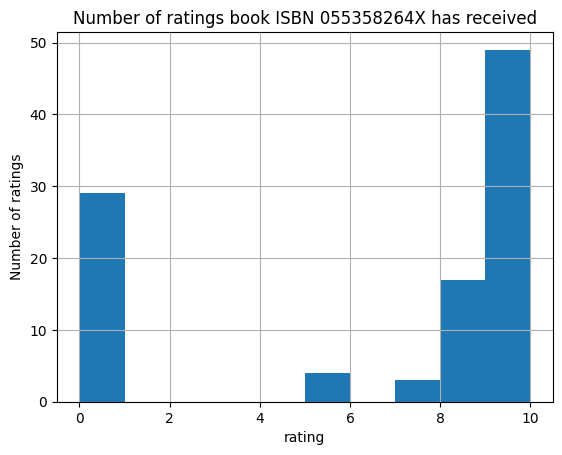

In [31]:
df_new.loc[df_new['ISBN'] == book]['bookRating'].hist()
plt.xlabel('rating')
plt.ylabel('Number of ratings')
plt.title('Number of ratings book ISBN 055358264X has received')
plt.show()

Ejemplo extraído de [acá](https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Building%20Recommender%20System%20with%20Surprise.ipynb)


## Referencias:

- [Documentación de Surprise](https://surpriselib.com/)
